In [1]:
### Imports
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part 1: BASIC VIDEO FILE MANAGEMENT

## Objectives

- Open an MP4 file.
- Display some important video parameters such as pixel resolution, frame rate,
video duration, and the number of frames.
- Access different frames within the video stream.
- Modify pixels in the sequence’s images. For example, you could modify colors
in a specific region of the image or apply some basic processing.
- Save the modified video stream into an MP4 file.


## Code

### Video loading

In [2]:
INPUT_PATH = "videoTEST03.mp4"    
  
if not os.path.exists(INPUT_PATH):  
    raise FileNotFoundError(f"Video not found: {INPUT_PATH}")  

vcap = cv2.VideoCapture(INPUT_PATH)
if not vcap.isOpened():
    raise RuntimeError("Failed to open input video. Check the file/codec support.")

width  = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))    # Width of the video
height = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))   # Heigh of the video
fps    = vcap.get(cv2.CAP_PROP_FPS) or 0.0          # Frame rate
nframes= int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))    # Number of frames
duration = (nframes / fps) if fps > 0 else float('nan')  

print("Basic statistics:")
print('- Width: '+ str(width))
print('- Height: '+ str(height))
print('- Frame Rate: '+ str(fps))
print('- Number of frames: '+ str(nframes))
print("- Duration: "+ str(duration))




Basic statistics:
- Width: 640
- Height: 360
- Frame Rate: 12.5
- Number of frames: 2613
- Duration: 209.04


### Read different frames

Let's read and display different frames. Note, we store the displayed frames, this list could be usefull later...

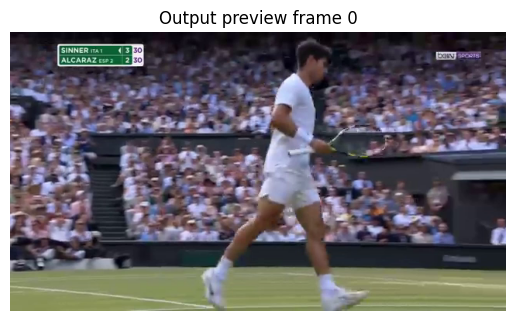

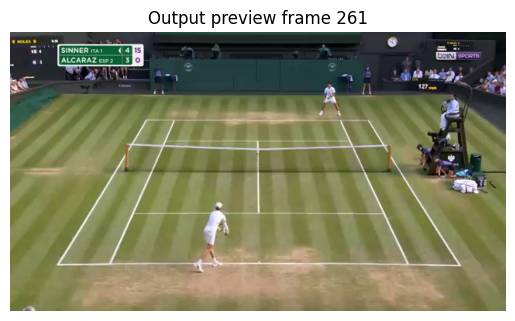

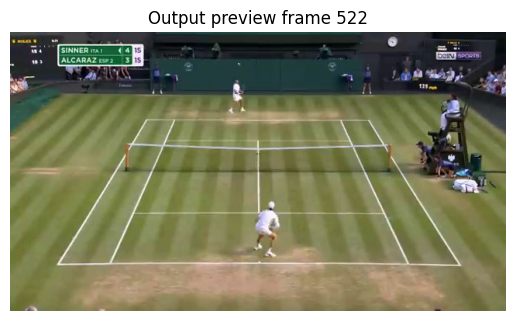

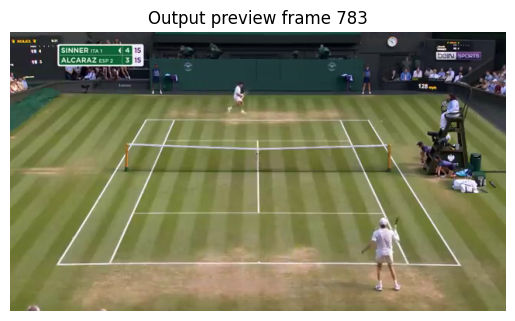

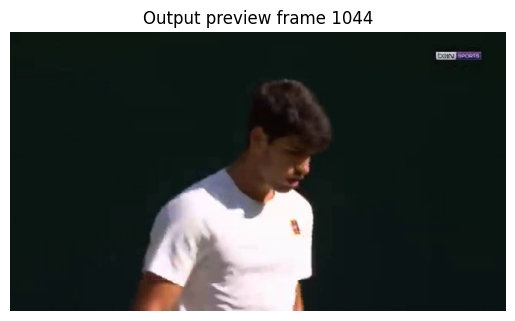

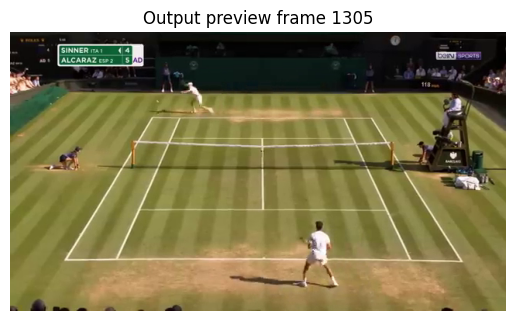

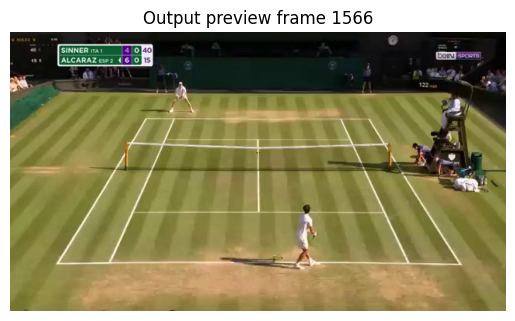

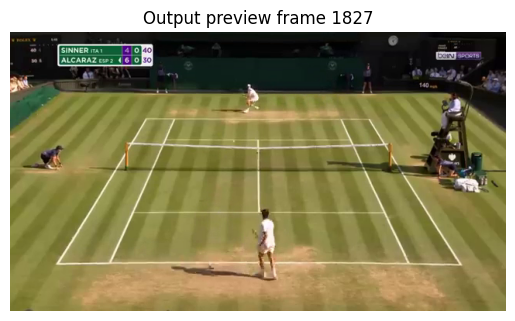

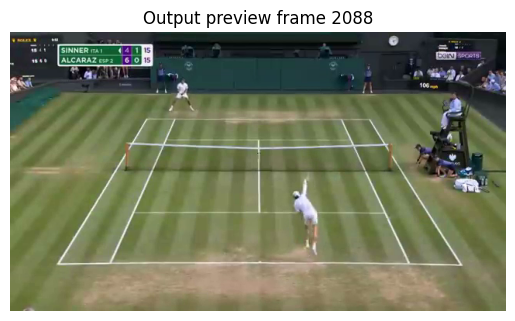

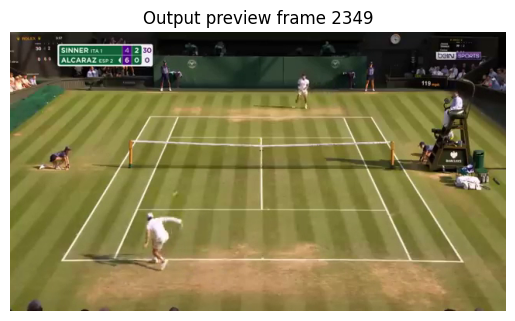

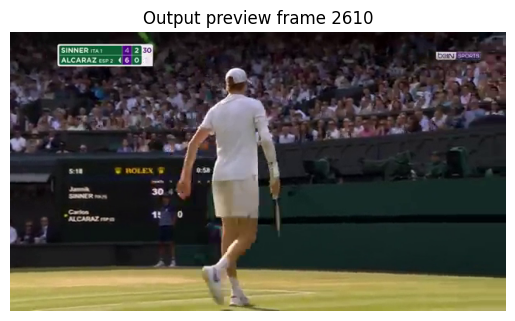

Preview complete.


In [3]:
frames_to_show = 10

list_frames_displayed = []

for idx in range(0, nframes, nframes//frames_to_show):
    vcap.set(cv2.CAP_PROP_POS_FRAMES, int(idx)) 
    ret, frame = vcap.read()
    if not ret:
        break
    list_frames_displayed.append(idx)
    plt.title(f"Output preview frame {idx}")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
vcap.release()
print("Preview complete.")

### Pixels modification and video saving


In this part, the main purpose is to apply a transformation to the video. To do that, we need to loop on each frame and apply the transformation on the frame. Here I have decided to create a checkboard effect on the video, using color inversion (negative).

In [4]:
OUTPUT_PATH = "Modified_"+INPUT_PATH

def try_open_writer(path, fps, size, candidates=("avc1", "H264", "X264", "mp4v")):
    W, H = size
    for four in candidates:
        fourcc = cv2.VideoWriter_fourcc(*four)
        writer = cv2.VideoWriter(path, fourcc, fps, (W, H))
        if writer.isOpened():
            print(f"Opened writer with FourCC='{four}' -> {path}")
            return writer, four
        else:
            writer.release()
    return None, None



output_path = OUTPUT_PATH  # The output video file .mp4 after modifications
writer, used_fourcc = try_open_writer(output_path, fps, (width, height))
if writer is None:
    vcap.release()
    raise RuntimeError("Failed to open any MP4 writer. \nTry a different container (e.g., .avi with 'XVID') \nor install FFmpeg-backed OpenCV.")
print("Using codec:", used_fourcc, "at", fps, "FPS, size:", (width, height))

Opened writer with FourCC='avc1' -> Modified_videoTEST03.mp4
Using codec: avc1 at 12.5 FPS, size: (640, 360)


In [5]:
vcap = cv2.VideoCapture(INPUT_PATH)
if not vcap.isOpened():
    raise RuntimeError("Failed to open input video. Check the file/codec support.")

processed = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# Block size for the modification
block_size = 20

try:
    while True:
        ret, frame = vcap.read()
        if not ret:   
            print("End of the video.")
            break 

        if frame is None:
            print("Empty frame")
            continue


        # Apply the effect to the video
        for y_block in range(0, height, block_size):
            for x_block in range(0, width, block_size):
                # Block inversion - to negative
                if ((x_block // block_size) + (y_block // block_size)) % 2 == 1:
                    block = frame[y_block:y_block+block_size, x_block:x_block+block_size]
                    frame[y_block:y_block+block_size, x_block:x_block+block_size] = 255 - block


        txt = f"Frame {processed}"
        cv2.putText(frame, txt, (12, 32), font, 1.0, (0, 0, 255), 2, cv2.LINE_AA)

        writer.write(frame)
        processed += 1
finally:
    vcap.release()
    writer.release()

print(f"Done. Processed and wrote {processed} frames to {output_path}")
print("Output size (bytes):", os.path.getsize(output_path) if os.path.exists(output_path) else 0)
print(f"New video has been created: {OUTPUT_PATH}")

End of the video.
Done. Processed and wrote 2613 frames to Modified_videoTEST03.mp4
Output size (bytes): 72250314
New video has been created: Modified_videoTEST03.mp4


# Part 2:  VIDEO CUT DETECTION

## Objectives

- In a personal MP4 video or in one of the provided videos, perform cut detection
based on the sum of absolute value pixel color components differences. Temporal and spatial subsampling can be used for optimization.
- Try other methods to increase the quality of cut detection.
- Identify cut positions in the video directly (color inversion, inserted text...) and
in a saved external file, containing timestamps or frame numbers from the
video.

## Code

In this part of the report, we will test different methods to remove the shots of the video and keep only the relevant segments. The idea is to keep only the segment where the player's are playing.

**Absolute value of pixel color**

In [6]:
# Compute the mean value of the absolute difference between two successive frames  
def mean_abs_diff_between_frames(frame1_bgr, frame2_bgr):
    diff_b=np.mean(np.abs(frame1_bgr[:,:,0]-frame2_bgr[:,:,0]))
    diff_g=np.mean(np.abs(frame1_bgr[:,:,1]-frame2_bgr[:,:,1]))
    diff_r=np.mean(np.abs(frame1_bgr[:,:,2]-frame2_bgr[:,:,2]))
    return diff_b + diff_g + diff_r  # if this value is high, we can deduce there is a cut.

**Brightness & contrast**

In [7]:
# Compute luminance stats on the 'frame_bgr' frame : mean value and std  
def luminance_stats(frame_bgr):  
    # Convert the frame 'frame_bgr' to YCrCb and take Y channel (0)  
    ycbcr = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2YCrCb)  
    Y = ycbcr[:, :, 0].astype(np.float32)  
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)  
    return float(np.mean(Y)), float(np.std(Y)) #,np.mean(gray)), float(np.std(gray))  

**Mean of RGB values**

Note: This a video of Wimbledon: so use the green may be a good idea...

Here we will re-use the list of the displayed frames in the beggining to compare the values obtained with the frame content. It will be helpfull to define the threshold properly.

In [8]:
dict_res_mean_rgb = {"frame":[], "mean_R":[], "mean_G":[], "mean_B":[], "mean_tot":[]}

cap = cv2.VideoCapture(INPUT_PATH)

if not cap.isOpened():
    print("Error : video unreadable")
    exit()

i=0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # BGR mean
    moyenne_BGR = cv2.mean(frame)

    # convert to RGB
    moyenne_RGB = (moyenne_BGR[2], moyenne_BGR[1], moyenne_BGR[0])
    moyenne_col = sum(moyenne_RGB)/len(moyenne_RGB)

    dict_res_mean_rgb["frame"].append(i)
    dict_res_mean_rgb["mean_B"].append(moyenne_BGR[0])
    dict_res_mean_rgb["mean_G"].append(moyenne_BGR[1])
    dict_res_mean_rgb["mean_R"].append(moyenne_BGR[2])
    dict_res_mean_rgb["mean_tot"].append(moyenne_col)

    i += 1 

cap.release()
cv2.destroyAllWindows()

# df display 
df_mean_rgb = pd.DataFrame(dict_res_mean_rgb)

# to check if this method can succed (using the frames displayed in the beginning of the workflow)
comparative_rows = df_mean_rgb.iloc[list_frames_displayed]

print(comparative_rows)

      frame      mean_R      mean_G     mean_B    mean_tot
0         0   91.460221   87.103937  94.116632   90.893597
261     261  115.503333  116.849379  83.494145  105.282286
522     522  112.272244  113.566354  80.819948  102.219515
783     783  112.174805  113.547999  79.672626  101.798477
1044   1044   40.920117   46.664670  43.988355   43.857714
1305   1305  116.216072  108.257765  63.285282   95.919706
1566   1566  119.086549  112.329405  65.190417   98.868791
1827   1827  118.976068  112.132478  65.263251   98.790599
2088   2088  105.745747  111.993628  82.919245  100.219540
2349   2349  120.038941  112.658030  65.688624   99.461865
2610   2610   66.132760   63.452496  55.440356   61.675204


Processing the video: extract all the interresting characteristics.

In [11]:
# Open for scanning parameters  
vcap = cv2.VideoCapture(INPUT_PATH)  
if not vcap.isOpened():  
    raise RuntimeError("Failed to open video.")  
  
W = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))  
H = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))  
FPS = vcap.get(cv2.CAP_PROP_FPS) or 0.0  
N   = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))  

idxs = list(range(0, N, 1))  


times_sec = []  
frame_idx = []  
coeff_cut= []
bright= []
contrast = []
mean_B = []
mean_G = []
mean_R = []
  
vcap.set(cv2.CAP_PROP_POS_FRAMES, 0)    
ret, prev_frame =  vcap.read()
if not ret:  
    raise RuntimeError("Failed to read video.")   


for i in idxs:  
    vcap.set(cv2.CAP_PROP_POS_FRAMES, i)  
    ret, frametemp = vcap.read()  
    if not ret:  
        break  

    t = i / FPS if FPS > 0 else np.nan  
    frame=frametemp 

    meandiff=mean_abs_diff_between_frames(prev_frame, frame)
    m, s = luminance_stats(frame)  
    mean_BGR = cv2.mean(frame)

    
    times_sec.append(t)  
    frame_idx.append(i)  
    coeff_cut.append(meandiff)
    bright.append(m)   
    contrast.append(s)
    mean_B.append(mean_BGR[0])
    mean_G.append(mean_BGR[1])
    mean_R.append(mean_BGR[2])
   
    prev_frame = frame  

  
vcap.release()  
print(f"Processed {len(frame_idx)} samples out of {N} frames.")

Processed 2613 samples out of 2613 frames.


**Store the result into a Dataframe**

In [12]:
## Results
df = pd.DataFrame({  
    'frame': frame_idx,  
    'time_sec': times_sec,
    "bright" : bright, 
    "contrast" : contrast, 
    'coeff_cut': coeff_cut, 
    "mean_blue" : mean_B,  
    "mean_green" : mean_G,  
    "mean_red" : mean_R
})  
df.head()

,frame,time_sec,bright,contrast,coeff_cut,mean_blue,mean_green,mean_red
0,0,0.00,89.156586,50.251064,0.000000,94.116632,87.103937,91.460221
1,1,0.08,87.707016,50.358135,348.593876,92.718455,85.723411,89.840603
2,2,0.16,85.712532,51.058922,347.945243,90.400365,83.862622,87.712018
3,3,0.24,83.763420,51.256649,352.241272,88.440681,82.002830,85.581332
4,4,0.32,82.361305,51.530140,349.067574,87.150078,80.688832,83.975026


Plot the results

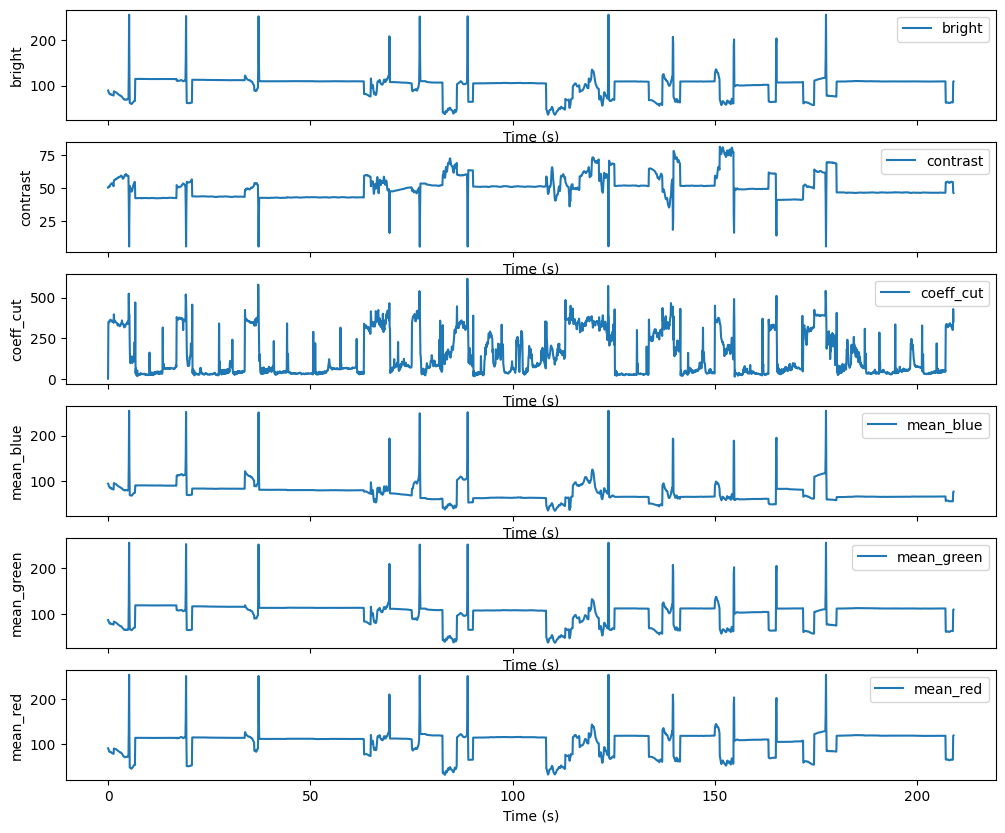

In [13]:
fig, axes = plt.subplots(6, 1, figsize=(12, 10), sharex=True)  
axes[0].plot(df['time_sec'], df['bright'], label='bright')  
axes[0].set_xlabel('Time (s)')  
axes[0].set_ylabel('bright')  
axes[0].legend(loc='upper right')  
  
axes[1].plot(df['time_sec'], df['contrast'], label='contrast')   
axes[1].set_xlabel('Time (s)')  
axes[1].set_ylabel('contrast')  
axes[1].legend(loc='upper right')  

axes[2].plot(df['time_sec'], df['coeff_cut'], label='coeff_cut')   
axes[2].set_xlabel('Time (s)')  
axes[2].set_ylabel('coeff_cut')  
axes[2].legend(loc='upper right') 

axes[3].plot(df['time_sec'], df['mean_blue'], label='mean_blue')  
axes[3].set_xlabel('Time (s)')  
axes[3].set_ylabel('mean_blue')  
axes[3].legend(loc='upper right') 

axes[4].plot(df['time_sec'], df['mean_green'], label='mean_green')  
axes[4].set_xlabel('Time (s)')  
axes[4].set_ylabel('mean_green')  
axes[4].legend(loc='upper right') 

axes[5].plot(df['time_sec'], df['mean_red'], label='mean_red')   
axes[5].set_xlabel('Time (s)')  
axes[5].set_ylabel('mean_red')  
axes[5].legend(loc='upper right') 

Note that the RGB mean are similar to the bright (shape of the diagram).

The coeff_cut is very irregular, and all other metrics have a really similar diagram. So, I choose to use the mean_green value for the next steps. Why? Because the peaks are more significant in the RGB diagrams and the video takes place in Wimbledon, so using green is the best choice.

# Part 3: SHOT IDENTIFICATION

## Objectives

- In a tennis recording, after identifying the different shots, try to isolate those
corresponding to moments of effective play.
- Once effective play shots are identified, try to characterize the shots by player
motion. You can define queries that the characterizations you made can answer.
For example, you can try to identify shots in which a player approaches the net.
- Perform the same analysis on an athletics sequence in which you will try to
identify shots corresponding to pole vaulting or high jump. A more complex
query could be to distinguish between successful attempts and failed attempts.


## Code

Let's have a view on the number of segment identified with the diverses methods, and the number of frames allocated to the play sessions and the off sessions.

In [14]:
from copy import deepcopy
dict_shot_res = {"method":[], "play_on":[], "play_off":[], "frames_play_on":[], "frames_play_off":[]}


def compute_stats_shots(df : pd.DataFrame, col_name : str, threshold_cut : list):
    df_temp = deepcopy(df)

    # Creation of a dedicated column
    df_temp['within_range'] = (df_temp[col_name] >= threshold_cut[0]) & (df_temp[col_name] <= threshold_cut[1])

    # Identify segment changes
    df_temp['change'] = df_temp['within_range'].ne(df_temp['within_range'].shift()).cumsum()

    # Count the number of values per segment within the range
    nb_values_within_range = df_temp[df_temp['within_range']].groupby('change').size()
    nb_values_outside_range = df_temp[~df_temp['within_range']].groupby('change').size()


    # Total number of values within and outside the range
    total_within = nb_values_within_range.sum()
    total_outside = nb_values_outside_range.sum()

    dict_shot_res['method'].append(col_name)
    dict_shot_res['play_on'].append(len(nb_values_within_range))
    dict_shot_res['play_off'].append(len(nb_values_outside_range))
    dict_shot_res['frames_play_on'].append(total_within)
    dict_shot_res['frames_play_off'].append(total_outside)



dict_param = {"coeff_cut":[0,200], "contrast":[30,52], "bright":[100,120], "mean_green":[105, 120]} # {col_name : threshold_value}

for method, threshold_cut in dict_param.items():
    compute_stats_shots(df=df, col_name=method, threshold_cut=threshold_cut)


df_shot_res = pd.DataFrame(dict_shot_res)

print(df_shot_res)


       method  play_on  play_off  frames_play_on  frames_play_off
0   coeff_cut       72        72            1810              803
1    contrast       39        38            1923              690
2      bright       27        27            1933              680
3  mean_green       20        20            1759              854


### New video extraction (play on only - almost)

Use of the green value as a criteria for the video segmentation 

In [15]:
OUTPUT_PATH = "method_1_slice_" + INPUT_PATH

if not os.path.exists(INPUT_PATH):
    raise FileNotFoundError(f"Video not found: {INPUT_PATH}")

# Open the input video
vcap = cv2.VideoCapture(INPUT_PATH)
fps = vcap.get(cv2.CAP_PROP_FPS)
width = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Prepare the VideoWriter for the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1' for H.264 if available
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

meandiff = 0
vcap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, prev_frame = vcap.read()

threshold_cut_up = 116
threshold_cut_down = 106

try:
    while True:
        ret, frame = vcap.read()
        if not ret:
            break
        mean_BGR = int(cv2.mean(frame)[1])
        if mean_BGR <= threshold_cut_up and mean_BGR >= threshold_cut_down:
            # Write the frame to the new video
            out.write(frame)
        prev_frame = frame

finally:
    vcap.release()
    out.release()
    print(f"New video saved: {OUTPUT_PATH}")


New video saved: method_1_slice_videoTEST03.mp4


### Other method - background and fixed point analysis

This is another method, not based on a statistical analysis of the video, neither of its global properties. Here, I perform a local analysis. I will identify some fixed pixels during game sessions, with fixed RGB values. The all points in then to crete threshold to discriminate frames of play of others. 

**To get the coord of a pixel**

The next chunck allow us to obtain the pixel coordonates and RGB values in the frames clicked.

In [16]:
# Function to get clic coords
def get_pixel_coordinates(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Coordonnées du pixel : (x={x}, y={y})")
        print(f"Valeur BGR du pixel : {frame[y, x]}")


cap = cv2.VideoCapture(INPUT_PATH)  

cv2.namedWindow("Video")
cv2.setMouseCallback("Video", get_pixel_coordinates)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Video", frame)

    key = cv2.waitKey(30)
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


**Fixed point obtained** with the previous chunck

Here, this code introduce the method I will used to extract the relevant sequences + It display the fixed point choosen.

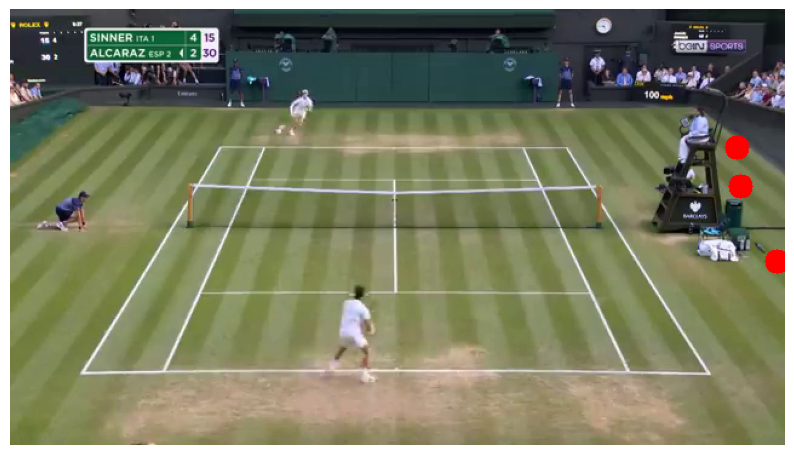

In [ ]:
input_video = INPUT_PATH

# Coordinates of the central pixels - obtained with the previous chunck
pixel_x1, pixel_y1 = 633, 208
pixel_x2, pixel_y2 = 603, 146
pixel_x3, pixel_y3 = 600, 114

# Define thresholds for the Green (G) channel only - one value is enough to discriminate the frames and sequences. 
seuil_G_min, seuil_G_max = 65, 135

# Radius of the circle (in pixels)
rayon = 10  # Adjust this value to change the circle size

# Read the input video
cap = cv2.VideoCapture(input_video)

# Get video properties (width, height, FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)


i = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Get BGR values of the pixels
    pixel_value_1 = frame[pixel_y1, pixel_x1]
    pixel_value_2 = frame[pixel_y2, pixel_x2]
    pixel_value_3 = frame[pixel_y3, pixel_x3]

    # Extract BGR components
    B1, G1, R1 = pixel_value_1
    B2, G2, R2 = pixel_value_2
    B3, G3, R3 = pixel_value_3

    # Check if the pixels meet the condition
    if (seuil_G_min <= G1 <= seuil_G_max) and \
       (seuil_G_min <= G2 <= seuil_G_max) and \
       (seuil_G_min <= G3 <= seuil_G_max):

        # Draw a red circle around each central pixel
        cv2.circle(frame, (pixel_x1, pixel_y1), rayon, (0, 0, 255), -1)  # (0, 0, 255) = red in BGR, -1 = filled
        cv2.circle(frame, (pixel_x2, pixel_y2), rayon, (0, 0, 255), -1)
        cv2.circle(frame, (pixel_x3, pixel_y3), rayon, (0, 0, 255), -1)

        if i > 100:
            # Convert the frame from BGR (OpenCV) to RGB (Matplotlib)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the frame in the notebook
            plt.figure(figsize=(10, 6))  # Display size
            plt.imshow(frame_rgb)
            plt.axis('off')  # Hide axes
            plt.show()
            break

        i += 1


# Release resources
cap.release()
cv2.destroyAllWindows()

**Slice the original video**

Here we process to the sequences extraction and the new video construction.

In [18]:
input_video = INPUT_PATH
output_video = "method_2_slice_"+INPUT_PATH

# Pixel coords
pixel_x1, pixel_y1 = 633, 208
pixel_x2, pixel_y2 = 603, 146
pixel_x3, pixel_y3 = 600, 114


# Define BGR threshold
seuil_B_min, seuil_B_max = 30, 80  
seuil_G_min, seuil_G_max = 65, 135  
seuil_R_min, seuil_R_max = 70, 135 


cap = cv2.VideoCapture(input_video)

# get the video property
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Get the BGR value of the pixels
    pixel_value_1 = frame[pixel_y1, pixel_x1]
    pixel_value_2 = frame[pixel_y2, pixel_x2]
    pixel_value_3 = frame[pixel_y3, pixel_x3]

    # Extraction of BGR components.
    B1, G1, R1 = pixel_value_1
    B2, G2, R2 = pixel_value_2
    B3, G3, R3 = pixel_value_3

    if (seuil_G_min <= G1 <= seuil_G_max) and \
    (seuil_G_min <= G2 <= seuil_G_max) and \
    (seuil_G_min <= G3 <= seuil_G_max):
        out.write(frame)


# Free the ressources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Video save as : {output_video}")


Video save as : method_2_slice_videoTEST03.mp4


### Detect if a player is close from the net

Hre is the code for an additional analysis: detect if a player is close from the net or not. This is experimental, but there are good ideas of maniulation fo the frames.

In [19]:
input_video = "method_2_slice_"+INPUT_PATH

cap = cv2.VideoCapture(input_video)

# Background substractor initialization
fgbg = cv2.createBackgroundSubtractorMOG2()

# spatial requirement (= area where the players are considered close to the net)
filet_line_up = int(0.35 * cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
filet_line_down = int(0.65 * cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Variables for the temporal filter
compteur_frames_filet = 0
frames_threshold = 3  # Number of consecutive frames required (just < 1s - remember there are 25 fps)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Background substraction
    fgmask = fgbg.apply(frame)

    # Mask cleaning
    kernel = np.ones((5, 5), np.uint8)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    player_at_net = False
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter small contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Check if a player is close from the bet
                if cy < filet_line_down and cy > filet_line_up:
                    player_at_net = True

    
    # Mise à jour du compteur de frames
    if player_at_net :
        compteur_frames_filet += 1
    else:
        compteur_frames_filet = 0

    if compteur_frames_filet >= frames_threshold:
        cv2.putText(frame, "Player at net !", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Draw lines
    cv2.line(frame, (0, filet_line_up), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), filet_line_up), (255, 0, 0), 2)
    cv2.line(frame, (0, filet_line_down), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), filet_line_down), (255, 0, 0), 2)

    cv2.imshow("Détection", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


**Explainations of this code:**

- background substraction: isolation of the moving objects in the video

- mask cleaning : remove the noise using morphological operation (here an opening)

- find and check contours : to verify if it could represent a player near at the net or not.

- temporal filter : if the player stay near to the net during multiple frames (here at least 3 consecutive frames).

**Notes and remarks:**

This code seems to works, but because of noise or external elements, the player_at_net variable is often set at "True" for nothing.

Still I found this operation interresting.